In [1]:
# importamos librerias a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder,CountFrequencyEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import joblib

In [2]:
#cargamos el dataset
data = pd.read_csv("train.csv")
data

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,14549287,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,False,...,40.709025,-73.939405,one room bushwick,Williamsburg,0,NaN,https://a0.muscache.com/im/pictures/55162426/6...,11206.0,1.0,1.0
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,True,...,33.871549,-118.396053,Spacious Hermosa 2 BR on PCH,Hermosa Beach,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,True,...,40.706749,-73.942377,Modern 2 Bedroom Apartment in Williamsburg,Williamsburg,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206.0,2.0,2.0
74109,17045948,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,True,...,40.738535,-74.000157,Designer's Apartment in HEART of NYC,West Village,0,NaN,https://a0.muscache.com/im/pictures/b3971b63-0...,10011,0.0,2.0


In [3]:
#vemos sus dimensiones
data.shape

(74111, 29)

In [4]:
#vemos los tipos de datos
data.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

In [5]:
#funcion para categorizar las variables
def getColumnTypes(dataset):
     ''' Descripcion: Esta función extrae el tipo de dominio de las columnas de un dataset.
         Entradas: Pandas Dataframe  
         Salida: Tupla con arreglo que contine nombres de las columnas. '''
     
     continuas = []
     discretas = []
     categoricas = []
     for col in dataset.columns:
          if((dataset[col].dtype == 'int64') or (dataset[col].dtype == 'float64')):
               if(len(dataset[col].unique()) > 30): #criterio para discretas o continuas
                    continuas.append(col)
               else:
                    discretas.append(col)
          else:
               categoricas.append(col)

     return continuas, discretas, categoricas

In [6]:
#vemos como estan distribuidas las variables segun su tipo
continuas, discretas, categoricas = getColumnTypes(data)
print(continuas)
print(discretas)
print(categoricas)

['id', 'log_price', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating']
['accommodates', 'bathrooms', 'bedrooms', 'beds']
['property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'description', 'first_review', 'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'host_since', 'instant_bookable', 'last_review', 'name', 'neighbourhood', 'thumbnail_url', 'zipcode']


In [7]:
#extraemos las columnas con vacios
cols_con_na = [col for col in data.columns if (data[col].isnull().mean() > 0)]
cols_con_na

['bathrooms',
 'first_review',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_response_rate',
 'host_since',
 'last_review',
 'neighbourhood',
 'review_scores_rating',
 'thumbnail_url',
 'zipcode',
 'bedrooms',
 'beds']

In [8]:
#miramos las columnas que se pueden salvar
prop_nan_per_col = data[cols_con_na].isnull().mean()
prop_nan_per_col

bathrooms                 0.002699
first_review              0.214057
host_has_profile_pic      0.002537
host_identity_verified    0.002537
host_response_rate        0.246913
host_since                0.002537
last_review               0.213558
neighbourhood             0.092726
review_scores_rating      0.225635
thumbnail_url             0.110861
zipcode                   0.013035
bedrooms                  0.001228
beds                      0.001768
dtype: float64

In [9]:
#columnas rescatables 
col_res= [col for col in data.columns if (data[col].isnull().mean() >= 0 and data[col].isnull().mean() < 0.05)]
col_res

['id',
 'log_price',
 'property_type',
 'room_type',
 'amenities',
 'accommodates',
 'bathrooms',
 'bed_type',
 'cancellation_policy',
 'cleaning_fee',
 'city',
 'description',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_since',
 'instant_bookable',
 'latitude',
 'longitude',
 'name',
 'number_of_reviews',
 'zipcode',
 'bedrooms',
 'beds']

In [10]:
#viendo como estan los datos se tomaran solo las columnas porcentaje menor a 5% para la imputacion
# entonces el dataset final sería este 
datapre = data[col_res]
#quitamos la columna de id 
datapre = datapre.drop("id",axis=1)
datapre

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,host_identity_verified,host_since,instant_bookable,latitude,longitude,name,number_of_reviews,zipcode,bedrooms,beds
0,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,t,2012-03-26,f,40.696524,-73.991617,Beautiful brownstone 1-bedroom,2,11201,1.0,1.0
1,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,f,2017-06-19,t,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,6,10019,3.0,3.0
2,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,t,2016-10-25,t,40.808110,-73.943756,The Garden Oasis,10,10027,1.0,3.0
3,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,...,t,2015-04-19,f,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,0,94117.0,2.0,2.0
4,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,...,t,2015-03-01,t,38.925627,-77.034596,Great studio in midtown DC,4,20009,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,False,NYC,...,t,2013-03-24,f,40.709025,-73.939405,one room bushwick,0,11206.0,1.0,1.0
74107,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,True,LA,...,f,2016-05-03,f,33.871549,-118.396053,Spacious Hermosa 2 BR on PCH,16,90254,2.0,4.0
74108,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,True,NYC,...,t,2012-01-05,t,40.706749,-73.942377,Modern 2 Bedroom Apartment in Williamsburg,43,11206.0,2.0,2.0
74109,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,True,NYC,...,f,2017-09-17,t,40.738535,-74.000157,Designer's Apartment in HEART of NYC,0,10011,0.0,2.0


In [11]:
#volvemos a ver el tipo de datos que tenemos en las variables a utilizar
datapre.dtypes

log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
host_has_profile_pic       object
host_identity_verified     object
host_since                 object
instant_bookable           object
latitude                  float64
longitude                 float64
name                       object
number_of_reviews           int64
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

In [12]:
#volvemos a separar las variables del dataset final
#vemos como estan distribuidas las variables segun su tipo
continuaspre, discretaspre, categoricaspre = getColumnTypes(datapre)
print(continuaspre)
print(discretaspre)
print(categoricaspre)

['log_price', 'latitude', 'longitude', 'number_of_reviews']
['accommodates', 'bathrooms', 'bedrooms', 'beds']
['property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'description', 'host_has_profile_pic', 'host_identity_verified', 'host_since', 'instant_bookable', 'name', 'zipcode']


In [13]:
#seleccionamos la variable a predecir  y las variables predictoras

#Variable a predecir : cleaning_fee
#variables predictoras : ['accommodates','log_price', 'bathrooms', 'bedrooms', 'beds','number_of_reviews'
#'property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy', 'city', 'host_has_profile_pic', 'host_identity_verified'

In [14]:
###parte 2 ingenieria de caracteristicas
#cargamos la data final
dataf = datapre[['log_price','accommodates', 'bathrooms', 'bedrooms', 'beds','number_of_reviews','property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',  'host_has_profile_pic', 'host_identity_verified']].copy()


In [15]:
#columnas a tratar 
col_catsnan= [col for col in dataf.columns if (dataf[col].isnull().mean() > 0 and dataf[col].isnull().mean() < 0.05)]
col_catsnan

['bathrooms',
 'bedrooms',
 'beds',
 'host_has_profile_pic',
 'host_identity_verified']

In [16]:
#categorizamos las variables que vamos a usar 
continuasf, discretasf, categoricasf = getColumnTypes(dataf)
print(continuasf)
print(discretasf)
print(categoricasf)

['log_price', 'number_of_reviews']
['accommodates', 'bathrooms', 'bedrooms', 'beds']
['property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified']


In [17]:
#funcion para imputar medianas
def input_mediana(dataset,col):
    median= dataset[col].median()
    dataset[col] = np.round(dataset[col].fillna(median))


In [18]:
#imputacion de variables numericas
colsmedian= ['bathrooms',
 'bedrooms',
 'beds']
for col in colsmedian:
     input_mediana(dataf, col)



In [19]:
#validamos la imputaciones de medianas
col_catsnan2= [col for col in dataf.columns if (dataf[col].isnull().mean() > 0 and dataf[col].isnull().mean() < 0.05)]
col_catsnan2

['host_has_profile_pic', 'host_identity_verified']

In [20]:
# funcion de imputacion de variables  categoricas
def imputar_variables_categoricas(data2,col):
    
    valores_mas_comunes = data2[col].mode().iloc[0]

    data2[col] = data2[col].fillna(valores_mas_comunes)
        



In [21]:
#imputacion de variables numericas
colscate= ['host_has_profile_pic','host_identity_verified']
for col in colscate:
     imputar_variables_categoricas(dataf, col)


In [22]:
#validamos que ya no hayan ningun nulo
col_catsnan3= [col for col in dataf.columns if (dataf[col].isnull().mean() > 0 and dataf[col].isnull().mean() < 0.05)]
col_catsnan3

[]

In [23]:
##codificacion de variables categoricas
# funcion para categorizaar
def categ(dataset,col):
    col_freq_mapper = (dataset[col].value_counts().sort_values(ascending=False)).to_dict()
    dataset[col] = dataset[col].map(col_freq_mapper)



In [24]:
#aplicamos a nuestras variables categoricas 
for col in categoricasf:
     categ(dataf, col)

In [25]:
#transformacion logaritmica 
def log(dataset,col):
    dataset[col] = np.log(dataset[col])
    


In [26]:
#aplicamos la transformacion
for col in categoricasf:
     log(dataf, col)


In [27]:
#tratamiento de outliers
#funcion para graficas
#creamos la funcion para ver el comportamiento de las variables continuas
def plotDistBoxQQ(dataset, col):
     plt.figure(figsize=(20, 6))
     plt.subplot(1, 3, 1)
     sns.histplot(dataset[col], bins=30)
     plt.title("Histograma y Densidad")

     plt.subplot(1, 3, 2)
     sns.boxplot(y=dataset[col])
     plt.title("Boxplot")

     plt.subplot(1, 3, 3)
     stats.probplot(dataset[col], dist="norm", plot=plt)
     plt.title("Q-Q Plot")

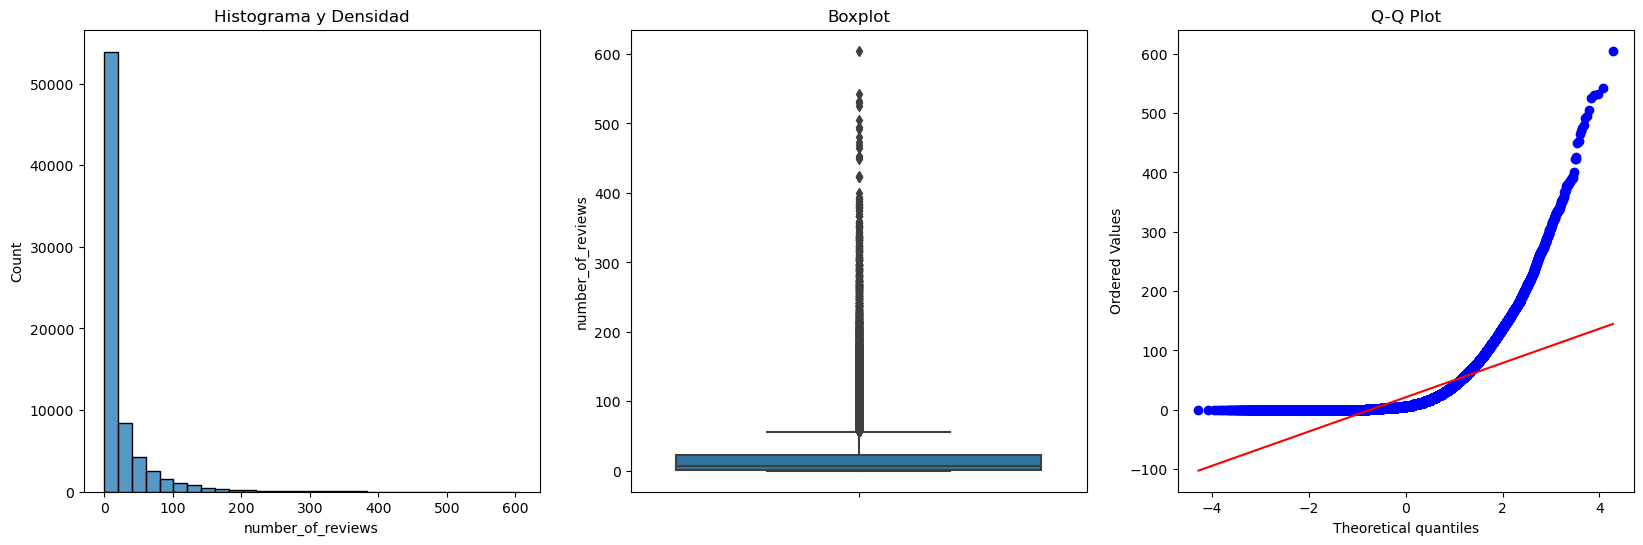

In [28]:
#vemos el comportamiento de la unica vaariable que le podemos aplicar tratamiento de outliers
plotDistBoxQQ(dataf, 'number_of_reviews')

In [29]:
def detectOutliersLimits(dataset, col):
     '''
     Descripción: Calcula los limites superiores e inferiores para detección de outliers.
     Input: dataset-> pandas dataframe, col -> string nombre de columna
     Output: tupla de floats con los limites superior e inferior
     '''
     IQR = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
     LI =  dataset[col].quantile(0.25) - (IQR*1.75)
     LS = dataset[col].quantile(0.75) + (IQR*1.75)

     return LI, LS

In [30]:
#tratamiento de outliers para la unida variable a la que podemos tratar
LI, LS = detectOutliersLimits(dataf, 'number_of_reviews')
dataf['number_of_reviews'] = np.where(dataf['number_of_reviews']  > LS, LS, 
                                                                       np.where(dataf['number_of_reviews']  == 0, 0.0001, dataf['number_of_reviews'] ))

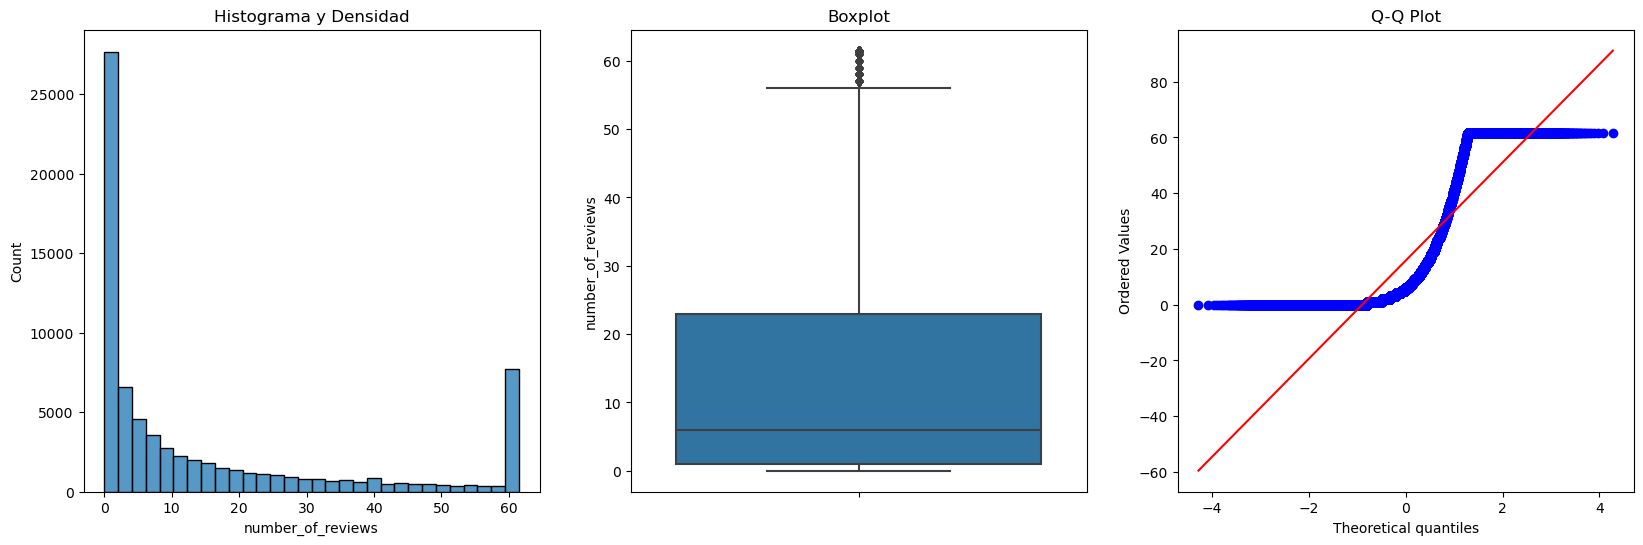

In [31]:
#vemos el resultado de tratar outliers
plotDistBoxQQ(dataf, 'number_of_reviews')

In [32]:
#aplicamos el scaler a las varibales 
from sklearn.preprocessing import StandardScaler
# seleccionamos predictores y target.
X = dataf.drop(['cleaning_fee'], axis=1)
y = dataf['cleaning_fee']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=2023)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

